In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


In [4]:
# Cell 2 - Load dataset & quick EDA
df = sns.load_dataset('titanic')   # seaborn dataset
print("Shape:", df.shape)
display(df.head())
print("\nInfo:")
print(df.info())
print("\nNumerical description:")
display(df.describe(include=[np.number]).T)
print("\nCategorical description:")
display(df.describe(include=['object','category','bool']).T)

print("\nMissing values per column:")
display(df.isna().sum().sort_values(ascending=False))


Shape: (891, 15)


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB
None

Numerical description:


,count,mean,std,min,25%,50%,75%,max
survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
sibsp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292



Categorical description:


,count,unique,top,freq
sex,891,2,male,577
embarked,889,3,S,644
class,891,3,Third,491
who,891,3,man,537
adult_male,891,2,True,537
deck,203,7,C,59
embark_town,889,3,Southampton,644
alive,891,2,no,549
alone,891,2,True,537



Missing values per column:


deck           688
age            177
embarked         2
embark_town      2
sex              0
pclass           0
survived         0
fare             0
parch            0
sibsp            0
class            0
adult_male       0
who              0
alive            0
alone            0
dtype: int64

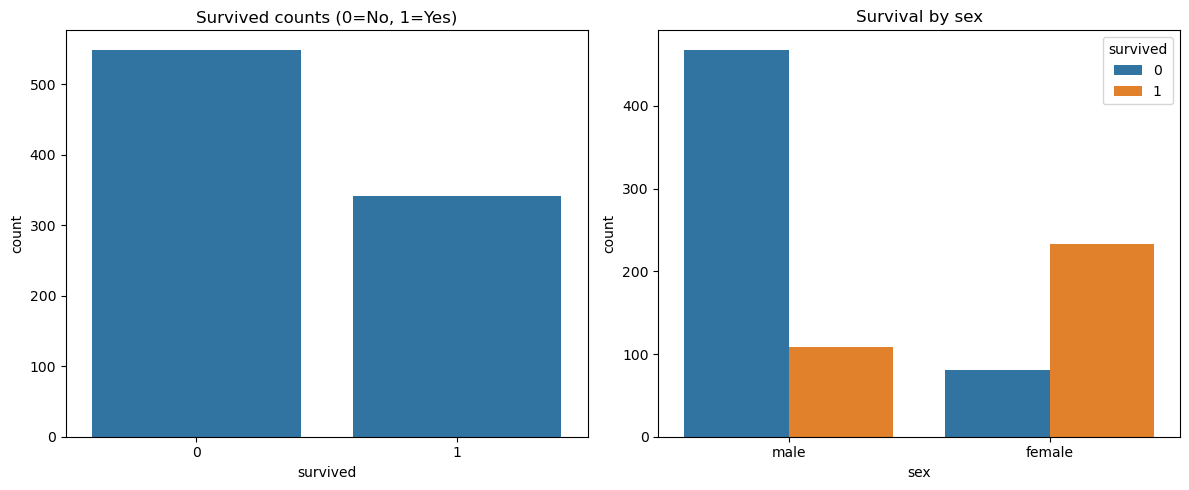

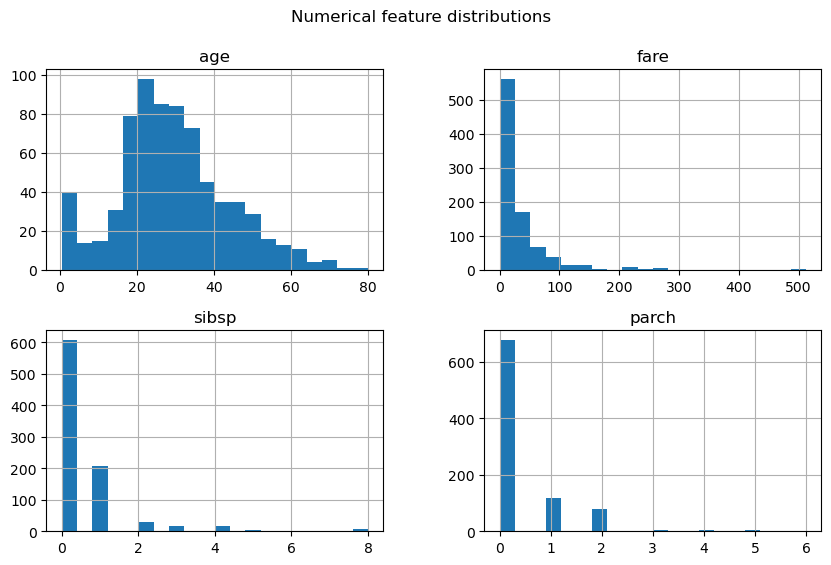

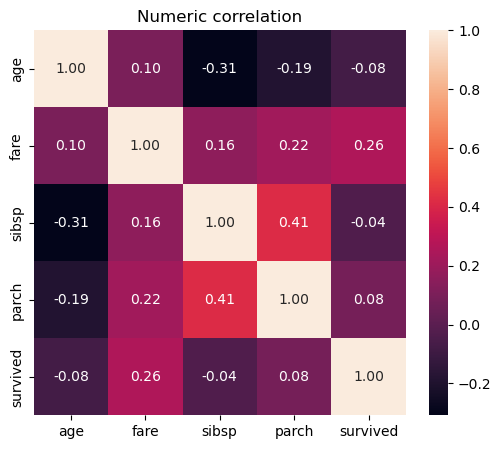

In [5]:
# Cell 3 - Visualizations
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.countplot(x='survived', data=df)
plt.title('Survived counts (0=No, 1=Yes)')

plt.subplot(1,2,2)
sns.countplot(x='sex', hue='survived', data=df)
plt.title('Survival by sex')
plt.tight_layout()
plt.show()

# Numeric histograms
numeric_cols = ['age','fare','sibsp','parch']
df[numeric_cols].hist(bins=20, figsize=(10,6))
plt.suptitle('Numerical feature distributions')
plt.show()

# Correlation among numeric features (including survived)
plt.figure(figsize=(6,5))
sns.heatmap(df[numeric_cols + ['survived']].corr(), annot=True, fmt=".2f")
plt.title('Numeric correlation')
plt.show()


In [6]:
# Cell 4 - Cleaning: drop columns & duplicates
data = df.copy()
to_drop = [c for c in ['deck','embark_town','alive','who'] if c in data.columns]
print("Dropping:", to_drop)
data.drop(columns=to_drop, inplace=True)

# Remove duplicates if any
print("Duplicates before:", data.duplicated().sum())
data.drop_duplicates(inplace=True)
print("Duplicates after :", data.duplicated().sum())

display(data.head())


Dropping: ['deck', 'embark_town', 'alive', 'who']
Duplicates before: 111
Duplicates after : 0


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,adult_male,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,True,False
1,1,1,female,38.0,1,0,71.2833,C,First,False,False
2,1,3,female,26.0,0,0,7.9250,S,Third,False,True
3,1,1,female,35.0,1,0,53.1000,S,First,False,False
4,0,3,male,35.0,0,0,8.0500,S,Third,True,True


In [7]:
# Cell 5 - Feature engineering
data['FamilySize'] = data['sibsp'].fillna(0) + data['parch'].fillna(0) + 1
data['IsAlone'] = (data['FamilySize'] == 1).astype(int)

# Title extraction only if 'name' exists
if 'name' in data.columns:
    data['title'] = data['name'].str.extract(r',\s*([^\.]+)\.', expand=False).str.strip().fillna('Unknown')
    common_titles = data['title'].value_counts().loc[lambda x: x>5].index.tolist()
    data['title'] = data['title'].apply(lambda t: t if t in common_titles else 'Rare')
else:
    print("No 'name' column in this dataset; skipping title extraction.")

display(data[['sibsp','parch','FamilySize','IsAlone']].head())


No 'name' column in this dataset; skipping title extraction.


,sibsp,parch,FamilySize,IsAlone
0,1,0,2,0
1,1,0,2,0
2,0,0,1,1
3,1,0,2,0
4,0,0,1,1


In [8]:
# Cell 6 - Outlier handling (IQR capping)
def iqr_cap(series):
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return series.clip(lower, upper)

for col in ['age','fare']:
    if col in data.columns:
        data[col] = iqr_cap(data[col])

display(data[['age','fare']].describe())


,age,fare
count,676.000000,780.000000
mean,29.762456,26.652527
std,14.585130,22.959236
min,0.420000,0.000000
25%,20.000000,8.050000
50%,28.000000,15.950000
75%,39.000000,34.375000
max,67.500000,73.862500


In [9]:
# Cell 7 - Prepare X, y and column lists
y = data['survived']
X = data.drop(columns=['survived'])

# Automatically detect numeric and categorical
num_cols = X.select_dtypes(include=['number']).columns.tolist()
cat_cols = X.select_dtypes(include=['object','category','bool']).columns.tolist()

print("Numeric columns:", num_cols)
print("Categorical columns:", cat_cols)


Numeric columns: ['pclass', 'age', 'sibsp', 'parch', 'fare', 'FamilySize', 'IsAlone']
Categorical columns: ['sex', 'embarked', 'class', 'adult_male', 'alone']


In [15]:
# Cell 8 - Preprocessing pipelines (compatible sklearn)
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))   # no sparse=False
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_cols),
    ('cat', categorical_transformer, cat_cols)
], remainder='drop')

logistic_pipeline = Pipeline([
    ('preproc', preprocessor),
    ('clf', LogisticRegression(max_iter=500))
])

knn_pipeline = Pipeline([
    ('preproc', preprocessor),
    ('clf', KNeighborsClassifier(n_neighbors=5))
])

print("Pipelines created successfully.")


Pipelines created successfully.


In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

print("Train shape:", X_train.shape)
print("Test shape:", X_test.shape)


Train shape: (624, 12)
Test shape: (156, 12)


In [17]:
logistic_pipeline.fit(X_train, y_train)
knn_pipeline.fit(X_train, y_train)

print("Models trained.")


Models trained.



Logistic Regression Accuracy = 0.8380
              precision    recall  f1-score   support

           0       0.85      0.89      0.87       110
           1       0.81      0.75      0.78        69

    accuracy                           0.84       179
   macro avg       0.83      0.82      0.83       179
weighted avg       0.84      0.84      0.84       179



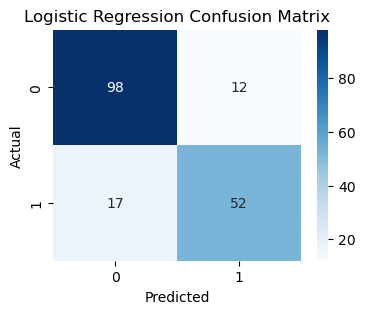


KNN Accuracy = 0.8212
              precision    recall  f1-score   support

           0       0.83      0.89      0.86       110
           1       0.80      0.71      0.75        69

    accuracy                           0.82       179
   macro avg       0.82      0.80      0.81       179
weighted avg       0.82      0.82      0.82       179



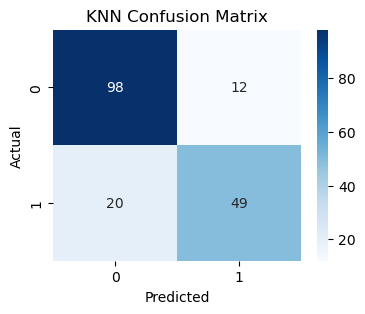

In [18]:
def evaluate(model, X_test, y_test, name):
    y_pred = model.predict(X_test)
    print(f"\n{name} Accuracy = {accuracy_score(y_test, y_pred):.4f}")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

evaluate(logistic_pipeline, X_test, y_test, "Logistic Regression")
evaluate(knn_pipeline, X_test, y_test, "KNN")



In [19]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_log = cross_val_score(logistic_pipeline, X_train, y_train, cv=skf)
cv_knn = cross_val_score(knn_pipeline, X_train, y_train, cv=skf)

print("Logistic Regression CV mean:", cv_log.mean())
print("KNN CV mean:", cv_knn.mean())



Logistic Regression CV mean: 0.8174234216487737
KNN CV mean: 0.7977937555402344


In [20]:
# Fit only the preprocessor to extract feature names
preprocessor.fit(X_train)

def get_feature_names_old(preprocessor, num_cols, cat_cols):
    names = list(num_cols)
    
    ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']

    # build names manually (old sklearn style)
    categories = ohe.categories_
    cat_feature_names = []
    for col_name, cats in zip(cat_cols, categories):
        cat_feature_names.extend([f"{col_name}_{cat}" for cat in cats])
    
    names.extend(cat_feature_names)
    return names

feature_names = get_feature_names_old(preprocessor, num_cols, cat_cols)

print("Number of final features:", len(feature_names))
print(feature_names[:30])



Number of final features: 19
['pclass', 'age', 'sibsp', 'parch', 'fare', 'FamilySize', 'IsAlone', 'sex_female', 'sex_male', 'embarked_C', 'embarked_Q', 'embarked_S', 'class_First', 'class_Second', 'class_Third', 'adult_male_False', 'adult_male_True', 'alone_False', 'alone_True']
